In [1]:
import os
import json
from groq import Groq
from openai import OpenAI

In [26]:
import pandas as pd
df = pd.read_json("hf://datasets/voidful/GSM-IC/gsm8k_test.jsonl", lines=True)

FileNotFoundError: datasets/voidful/GSM-IC/gsm8k_test.jsonl

In [27]:
df

,question,answer,n_steps
0,"Jeanne wants to ride the Ferris wheel, the rol...",8,2
1,Megan is an actress. She was the lead actress ...,20,2
2,When Jayson is 10 his dad is four times his ag...,28,3
3,Teairra has 5 shirts and 24 pairs of pants in ...,21,3
4,John decides to replace all his VHS with DVDs....,800,2
...,...,...,...
995,Kathleen receives a weekly allowance for compl...,150,5
996,Ashley and her family went to the movies on Sa...,30,5
997,A singer is planning on releasing 3 songs in a...,300,2
998,"Two apartment roommates split the rent, utilit...",300,3


In [2]:
#open dataset and store it as a JSON object
with open('../GSM-IC/GSM-IC_mstep.json', 'r') as file:
    questions = json.load(file)
with open('../GSM-IC/GSM-IC_2step.json', 'r') as file:
    questions2 = json.load(file)
    #initialize the Groq client. This allows us to query Llama3 (or another model) from my Groq account
#todo: store the api_key in a secure way!
# client = Groq(
    # api_key=os.environ.get("GROQ_API_KEY")
    # api_key='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'
# )
client = OpenAI(api_key=open("api.txt").read())

In [22]:
[i for i in questions if i['n_steps'] == 7]

[{'original_question': 'Jean has three times as much money as Jane. They have a combined total of $76. How much money does Jean have?',
  'answer': '57',
  'new_question': "Jean has three times as much money as Jane. They have a combined total of $76. Jean's father bought 10000 tomatoes from the grocery store. How much money does Jean have?",
  'n_steps': 7,
  'role': "Jean's father",
  'number': '10000',
  'sentence_template': '{role} bought {number} tomatoes from the grocery store.',
  'role_label': 'overlapped',
  'number_label': 'out_range',
  'sentence_label': 'out_topic'},
 {'original_question': 'Jean has three times as much money as Jane. They have a combined total of $76. How much money does Jean have?',
  'answer': '57',
  'new_question': "Jean has three times as much money as Jane. They have a combined total of $76. The shoe size of Jean's sister is 50000. How much money does Jean have?",
  'n_steps': 7,
  'role': "Jean's sister",
  'number': '50000',
  'sentence_template': '

In [6]:
#todo: 1. answer_prompt is the current way of forcing the model to output its answer in predictable format. Find a better way to extract the numerical answer from the model's output. (maybe: require JSON output)

#todo: 2. clean up the answer. Ex. remove $, %, inches, etc. 

def single_query(query):
    """
    query the model with a single question
    input: what you would type in the chat box to ask the model a question
    output: the model's output in response to your query 
    """

    
    answer_prompt='The last sentence of your response must be in the form "The answer is [your answer]".'
    chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": query + answer_prompt,
        }
    ],
    model="gpt-3.5-turbo-0125",
    )
    response = chat_completion.choices[0].message.content
    return response 


In [7]:
#todo: shouldn't need to separate the two queries like this
def multiple_queries(question_type='original_question', num_questions=5):
    """
    query the model sequentially with multiple questions from the dataset 
    Args: question_type: specify whether to query the model with the original question or the new question 
        num_questions: the number of questions (mainly for testing a few questions at a time)
    
    """
    for idx, question in enumerate(questions):
        if idx < num_questions:
            query = question[question_type]
            response = single_query(query)
            print(response)
            print('--------------------------------------------------')

In [49]:
import tqdm
import time
#todo: shouldn't need to separate the two queries like this
def get_answers(questions, question_type='original_question', num_questions=5):
    """
    query the model sequentially with multiple questions from the dataset 
    Args: question_type: specify whether to query the model with the original question or the new question 
        num_questions: the number of questions (mainly for testing a few questions at a time)
    
    """
    answers = {}
    for idx, question in tqdm.tqdm(list(enumerate(questions[:num_questions]))):
        if idx < num_questions:
            query = question[question_type]
            try:
                response = single_query(query)
            except Exception as e:
                print(e, "Sleeping")
                time.sleep(120)
                continue
            # print(response)
            try:
                print(response)
                answer = response.split("he answer is")[1]#.strip("$")
                # print(question['answer'] in answer, question['answer'], answer, question, response)
                answers[idx] = [question['answer'] in answer, answer]
            except Exception as e:
                print(e)
                # pass
                # print(response, question['answer'])
                # input()
        else:
            break
    return answers

In [56]:
import collections
import tqdm
k = collections.defaultdict(list)
r = collections.defaultdict(list)
for idx, row in tqdm.tqdm(list(df.iterrows())):
    try:
        steps = row['n_steps']
        query = row['question']
        a = row['answer']
        response = single_query(query)
        answer = response.split("he answer is")[1]#.strip("$")
        k[steps].append(a in answer or ',' in answer)
        r[steps].append(response)
    except Exception as e:
        print(e)

 10%|████▏                                   | 105/1000 [01:42<22:00,  1.48s/it]

list index out of range


 37%|██████████████▊                         | 371/1000 [07:26<09:19,  1.12it/s]

list index out of range


 80%|████████████████████████████████▏       | 804/1000 [14:31<03:14,  1.01it/s]

list index out of range


100%|███████████████████████████████████████| 1000/1000 [17:37<00:00,  1.06s/it]


In [57]:
lns = collections.defaultdict(list)
for a, b in r.items():
    for i, q in enumerate(b):
        lns[len(q)].append(k[a][i])

In [58]:
lnss = collections.defaultdict(list)
for a, b in r.items():
    for q in b:
        lnss[a].append(len(q))

In [66]:
import statistics as st
for k in range(0, 1000, 10):
    x = []
    for i in range(k, k+10):
        x.extend(lns[i])
    print(f"{k}-{k+10}: {0 if len(x) == 0 else st.mean(x)} {len(x)}")

0-10: 0 0
10-20: 0.25 8
20-30: 0.625 8
30-40: 0.2 5
40-50: 0.4782608695652174 23
50-60: 0.5102040816326531 49
60-70: 0.4583333333333333 48
70-80: 0.46153846153846156 39
80-90: 0.6521739130434783 23
90-100: 0.6086956521739131 23
100-110: 0.5 16
110-120: 0.6538461538461539 26
120-130: 0.9411764705882353 17
130-140: 1 13
140-150: 0.8125 16
150-160: 0.875 8
160-170: 0.8181818181818182 22
170-180: 1 14
180-190: 0.9090909090909091 22
190-200: 0.8461538461538461 13
200-210: 0.8461538461538461 13
210-220: 0.6470588235294118 17
220-230: 0.85 20
230-240: 0.75 20
240-250: 0.8 25
250-260: 0.8 15
260-270: 0.8947368421052632 19
270-280: 0.8461538461538461 13
280-290: 0.8181818181818182 22
290-300: 0.8235294117647058 17
300-310: 0.6956521739130435 23
310-320: 0.85 20
320-330: 0.8421052631578947 19
330-340: 0.7647058823529411 17
340-350: 0.8333333333333334 18
350-360: 0.9047619047619048 21
360-370: 0.8823529411764706 17
370-380: 0.8235294117647058 17
380-390: 0.9473684210526315 19
390-400: 0.666666666

In [55]:
[len(k[i]) for i in [2, 3, 4, 5, 6, 7, 8, 9]]

TypeError: 'int' object is not subscriptable

In [34]:
for a, b in sorted(k.items(), key=lambda a:a[0]):
    print(a, sum(1 for i in b if i) / len(b))

2 0.8636363636363636
3 0.6597222222222222
4 0.7285714285714285
5 0.6384615384615384
6 0.6111111111111112
7 0.7619047619047619
8 0.6
9 0.0


In [40]:
answers = get_answers(questions2, question_type='original_question', num_questions=100)

100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


In [41]:
answers_steps = []
for steps in [3, 4, 5, 6, 7]:
    answers_steps.append(get_answers([i for i in questions if i['n_steps'] == steps], question_type='original_question', num_questions=100))

100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.05it/s]


In [51]:
answers_steps = []
for steps in [5]:
    answers_steps.append(get_answers([i for i in questions if i['n_steps'] == steps], question_type='new_question', num_questions=100))

  1%|▍                                          | 1/100 [00:01<02:23,  1.45s/it]

To find the total number of beads Kylie uses to make her jewelry, we first need to calculate the number of beads used for each type of jewelry.

For the necklaces: 10 necklaces * 20 beads = 200 beads
For the bracelets: 5 bracelets * 10 beads = 50 beads
For the earrings: 7 earrings * 5 beads = 35 beads

Now, we add up the total number of beads used:
200 beads (necklaces) + 50 beads (bracelets) + 35 beads (earrings) = 285 beads

Therefore, Kylie uses a total of 285 beads to make all her jewelry. 
The answer is 285 beads.


  2%|▊                                          | 2/100 [00:03<02:40,  1.64s/it]

First, let's calculate the total number of hours the cobbler works in a week:

Monday to Thursday: 4 days * 8 hours/day = 32 hours
Friday: 3 hours

Total hours worked in a week = 32 hours + 3 hours = 35 hours

Now, let's calculate the total number of pairs of shoes the cobbler can mend in a week:

Pairs of shoes mended in an hour = 3 pairs
Pairs of shoes mended in a week = 3 pairs/hour * 35 hours = 105 pairs

Therefore, the cobbler can mend 105 pairs of shoes in a week.

The answer is 105.


  3%|█▎                                         | 3/100 [00:04<02:29,  1.54s/it]

First, let's find out how many pounds Ajax's current weight of 80 kilograms is:

80 kg x 2.2 lbs/kg = 176 pounds

Next, let's calculate how many pounds Ajax will lose in one day by exercising for 2 hours:

1.5 lbs/hour x 2 hours = 3 pounds/day

Now, let's find out how many pounds Ajax will lose in two weeks by exercising for 2 hours every day:

3 pounds/day x 14 days = 42 pounds

Finally, let's calculate Ajax's new weight after losing 42 pounds:

176 pounds - 42 pounds = 134 pounds

The answer is 134 pounds.


  4%|█▋                                         | 4/100 [00:05<02:09,  1.35s/it]

Tomas ate 24 ounces of fudge (1.5 pounds * 16 ounces/pound), Katya ate 8 ounces of fudge (0.5 pounds * 16 ounces/pound), and Boris ate 32 ounces of fudge (2 pounds * 16 ounces/pound). In total, they ate 64 ounces of fudge (24 + 8 + 32). 

The answer is 64 ounces.


  5%|██▏                                        | 5/100 [00:06<01:35,  1.01s/it]

Annie had 5 brownies left. The answer is 5.


  6%|██▌                                        | 6/100 [00:07<01:40,  1.07s/it]

If Jude sold 16 tickets, then Andrea sold 32 tickets (twice as many as Jude) and Sandra sold 20 tickets (4 more than half of Jude's sales). So, a total of 16 + 32 + 20 = 68 tickets were sold. 

Adding Tom's 8 tickets for the basketball game, the total number of tickets sold is 68 + 8 = 76.

Therefore, there are 100 - 76 = 24 tickets that still need to be sold.

The answer is 24.


  7%|███                                        | 7/100 [00:07<01:17,  1.20it/s]

The total cost of the entire gardening project is $6,600.

The answer is $6,600.


  8%|███▍                                       | 8/100 [00:09<01:32,  1.00s/it]

First, let's calculate the total number of beads used to make the necklaces:
10 necklaces * 20 beads = 200 beads

Now, let's calculate the total number of beads used to make the bracelets:
5 bracelets * 10 beads = 50 beads

Now, let's calculate the total number of beads used to make the earrings:
7 earrings * 5 beads = 35 beads

Now let's add up all the beads used to make Kylie's jewelry:
200 beads (necklaces) + 50 beads (bracelets) + 35 beads (earrings) = 285 beads

The answer is 285 beads.


  9%|███▊                                       | 9/100 [00:10<01:36,  1.06s/it]

To find the total number of beads Kylie uses to make her jewelry, we need to calculate the following:

Total number of beads for necklaces = 10 necklaces * 20 beads/necklace = 200 beads
Total number of beads for bracelets = 5 bracelets * 10 beads/bracelet = 50 beads
Total number of beads for earrings = 7 earrings * 5 beads/earring = 35 beads

Adding all the beads together,
Total beads = 200 beads + 50 beads + 35 beads = 285 beads

Therefore, Kylie uses a total of 285 beads to make her jewelry.
The answer is 285 beads.


 10%|████▏                                     | 10/100 [00:11<01:35,  1.07s/it]

To calculate the total number of beads Kylie uses to make her jewelry, we need to add up the beads used for each item: 

Number of beads for necklaces = (10 necklaces) x (20 beads) = 200 beads
Number of beads for bracelets = (5 bracelets) x (10 beads) = 50 beads
Number of beads for earrings = (7 earrings) x (5 beads) = 35 beads

Total number of beads = 200 beads + 50 beads + 35 beads = 285 beads

The answer is 285 beads.


 11%|████▌                                     | 11/100 [00:11<01:15,  1.18it/s]

Annie had 3 brownies left.

The answer is 3.


 12%|█████                                     | 12/100 [00:12<01:19,  1.11it/s]

The cost of the rose bushes is 20 * $150 = $3000
The cost of the gardener is 5 * $30 * 4 = $600
The cost of the soil is 100 * $5 = $500
The total cost of the entire gardening project is $3000 + $600 + $500 = $4100
The answer is $4100.


 13%|█████▍                                    | 13/100 [00:14<01:46,  1.23s/it]

Let x be the number of problems Martha finished.
Jenna finished 4x - 2 problems.
Mark finished (4x - 2) / 2 = 2x - 1 problems.

Together, Martha, Jenna, and Mark finished x + 4x - 2 + 2x - 1 = 7x - 3 problems.

Since there are 20 problems total, the number of problems that no one finished is 20 - x - 4x + 2 - 2x + 1 = 20 - 7x + 3 = 23 - 7x.

Since Ada is not mentioned in the problem, she has not finished any problems. Thus, the number of problems that no one but Angela finished is 20 - x - 4x + 2 - 2x + 1 - 500 = 21 - 7x.

The answer is 21 - 7x.


 14%|█████▉                                    | 14/100 [00:15<01:45,  1.23s/it]

The cost of replanting the 20 rose bushes is 20 x $150 = $3000.
The cost of hiring the gardener for 4 days is 5 x 4 x $30 = $600.
The cost of 100 cubic feet of soil is 100 x $5 = $500.
The total cost of the gardening project is $3000 + $600 + $500 = $4100.
Mary's earnings from teaching piano are irrelevant to the total cost of the gardening project.
The answer is $4100.


 15%|██████▎                                   | 15/100 [00:17<01:43,  1.21s/it]

First, let's calculate how many pounds Ajax weighs initially:
80 kilograms * 2.2 pounds/kilogram = 176 pounds

Now, let's calculate how much weight Ajax will lose in one day:
1.5 pounds/hour * 2 hours = 3 pounds/day

Now, let's calculate how much weight Ajax will lose in two weeks (14 days):
3 pounds/day * 14 days = 42 pounds

Now, let's calculate how much Ajax will weight after losing 42 pounds:
176 pounds - 42 pounds = 134 pounds

The answer is 134 pounds.


 16%|██████▋                                   | 16/100 [00:18<01:46,  1.26s/it]

To find the total number of beads Kylie uses to make her jewelry, we can add up the number of beads used for each type of jewelry.

Number of beads used for necklaces: (10 necklaces) x (20 beads) = 200 beads
Number of beads used for bracelets: (5 bracelets) x (10 beads) = 50 beads
Number of beads used for earrings: (7 earrings) x (5 beads) = 35 beads

Total number of beads used: 200 beads + 50 beads + 35 beads = 285 beads

The answer is 285 beads.


 17%|███████▏                                  | 17/100 [00:20<01:54,  1.38s/it]

First, we need to calculate the total number of hours the cobbler works in a week:

Monday to Thursday: 8 hours/day x 4 days = 32 hours
Friday: 3 hours
Total hours worked in a week = 32 hours + 3 hours = 35 hours

Since the cobbler can mend 3 pairs of shoes in an hour, we can calculate the total number of pairs of shoes he can mend in a week:

3 pairs/hour x 35 hours = 105 pairs of shoes

The answer is 105.


 18%|███████▌                                  | 18/100 [00:20<01:30,  1.10s/it]

In a week, the cobbler can mend a total of 108 pairs of shoes.
The answer is 108.


 19%|███████▉                                  | 19/100 [00:21<01:31,  1.12s/it]

From Monday to Thursday, the cobbler works 4 days x 8 hours/day = 32 hours.
On Friday, the cobbler works 3 hours.
In total, the cobbler works 32 hours + 3 hours = 35 hours in a week.
Since the cobbler can mend 3 pairs of shoes in an hour, he can mend 3 pairs/hour x 35 hours = 105 pairs of shoes in a week.
Tom's reading habits are irrelevant to the cobbler's shoe-mending capacity.

The answer is 105.


 20%|████████▍                                 | 20/100 [00:22<01:13,  1.08it/s]

Annie had 6 brownies left. The answer is 6.


 21%|████████▊                                 | 21/100 [00:23<01:16,  1.03it/s]

Jude sold 16 tickets, so Andrea sold 2 * 16 = 32 tickets.
Half of the number of tickets Jude sold is 16 / 2 = 8, and Sandra sold 8 + 4 = 12 tickets.
Together, Jude, Andrea, and Sandra sold 16 + 32 + 12 = 60 tickets.
With the neighbor's planned purchase, 8 baseball tickets, there will be 100 - 60 - 8 = 32 more tickets that need to be sold.
The answer is 32.


 22%|█████████▏                                | 22/100 [00:23<01:04,  1.20it/s]

Tomas ate 24 ounces of fudge, Katya ate 8 ounces of fudge, and Boris ate 32 ounces of fudge. 

The answer is 64 ounces.


 23%|█████████▋                                | 23/100 [00:25<01:19,  1.03s/it]

First, we need to convert Ajax's weight of 80 kilograms to pounds:
80 kg * 2.2 = 176 pounds

Next, we need to calculate how many pounds Ajax will lose in 2 weeks if he exercises for 2 hours every day:
1.5 pounds/hour * 2 hours/day = 3 pounds/day
3 pounds/day * 14 days = 42 pounds

Now, we need to subtract the weight Ajax will lose from his initial weight:
176 pounds - 42 pounds = 134 pounds

Therefore, Ajax will weigh 134 pounds if he exercises for 2 hours every day for two weeks.
The answer is 134 pounds.


 24%|██████████                                | 24/100 [00:26<01:21,  1.07s/it]

Tomas ate 1.5 pounds = 24 ounces of chocolate fudge.
Katya ate 0.5 pounds = 8 ounces of peanut butter fudge.
Boris ate 2 pounds = 32 ounces of fudge.

Total amount of fudge eaten: 24 + 8 + 32 = 64 ounces.

The answer is 64 ounces.


 25%|██████████▌                               | 25/100 [00:27<01:29,  1.19s/it]

To find the total amount of fudge eaten by Tomas, Katya, and Boris, we need to convert all the quantities to the same unit of measurement. Since 1 pound is equal to 16 ounces, we can calculate as follows:

Tomas: 1.5 pounds = 1.5 x 16 = 24 ounces
Katya: 0.5 pounds = 0.5 x 16 = 8 ounces
Boris: 2 pounds = 2 x 16 = 32 ounces
Katya's mother: 2 pounds = 2 x 16 = 32 ounces

Total fudge eaten = 24 + 8 + 32 = 64 ounces

Therefore, Tomas, Katya, and Boris ate a total of 64 ounces of fudge.
The answer is 64 ounces.


 26%|██████████▉                               | 26/100 [00:29<01:39,  1.34s/it]

First, we need to convert all the weights into ounces:
- Tomas ate 1.5 pounds of fudge, which is 24 ounces (1 pound = 16 ounces).
- Katya ate 0.5 pounds of fudge, which is 8 ounces.
- Boris ate 2 pounds of fudge, which is 32 ounces.
- Katya's sister bought 1000 pounds of fudge, which is 16000 ounces.

Adding all these amounts together:
Total = 24 + 8 + 32 = 64 ounces

The answer is 64016.


 27%|███████████▎                              | 27/100 [00:30<01:34,  1.29s/it]

To find the number of problems no one but Angela finished, we first need to find out how many problems each of her friends finished.

Martha finished 2 problems
Jenna finished 4(2) - 2 = 6 problems
Mark finished 6 / 2 = 3 problems

Together, Angela's friends finished 2 + 6 + 3 = 11 problems.

Since there are 20 problems in total, the number of problems no one but Angela finished is 20 - 11 = 9.

So, the answer is 9.


 28%|███████████▊                              | 28/100 [00:32<01:33,  1.30s/it]

To convert the pounds of fudge eaten to ounces, we know that 1 pound is equivalent to 16 ounces. Therefore, Tomas ate 1.5 pounds * 16 ounces/pound = 24 ounces of fudge.
Katya ate 0.5 pounds * 16 ounces/pound = 8 ounces of fudge.
Boris ate 2 pounds * 16 ounces/pound = 32 ounces of fudge.
In total, they ate 24 ounces + 8 ounces + 32 ounces = 64 ounces of fudge.
The answer is 64 ounces.


 29%|████████████▏                             | 29/100 [00:33<01:35,  1.34s/it]

To find the total number of beads Kylie uses to make her jewelry, we first need to calculate the number of beads used for each type of jewelry she made:

Number of beads used for necklaces = 10 necklaces x 20 beads per necklace = 200 beads
Number of beads used for bracelets = 5 bracelets x 10 beads per bracelet = 50 beads
Number of beads used for earrings = 7 earrings x 5 beads per earring = 35 beads

Total number of beads used = 200 beads for necklaces + 50 beads for bracelets + 35 beads for earrings = 285 beads

Therefore, Kylie uses 285 beads in total to make her jewelry.

The answer is 285 beads.


 30%|████████████▌                             | 30/100 [00:33<01:12,  1.04s/it]

Annie had 6 brownies left.

The answer is 6.


 31%|█████████████                             | 31/100 [00:34<00:56,  1.21it/s]

The total cost of the entire gardening project is $4,600.

The answer is $4,600.


 32%|█████████████▍                            | 32/100 [00:35<01:00,  1.12it/s]

Jude sold 16 tickets, so Andrea sold 2 * 16 = 32 tickets.
Half the number of tickets Jude sold is 16 / 2 = 8 tickets.
Sandra sold 4 more than half the number of tickets Jude sold, so she sold 8 + 4 = 12 tickets.
In total, Andrea, Jude, and Sandra sold 32 + 16 + 12 = 60 tickets.
Therefore, 100 - 60 = 40 more tickets need to be sold.

The answer is 40.


 33%|█████████████▊                            | 33/100 [00:36<01:06,  1.00it/s]

First, we find out how many tickets Andrea and Sandra sold.
- Andrea sold twice as many tickets as Jude, so she sold 16*2 = 32 tickets.
- Sandra sold 4 more than half the number of tickets Jude sold, which is (16/2) + 4 = 12 tickets.

The total number of tickets sold so far is 16 (Jude) + 32 (Andrea) + 12 (Sandra) = 60 tickets.

Therefore, the number of tickets that still need to be sold is 100 - 60 = 40 tickets.

The answer is 40.


 34%|██████████████▎                           | 34/100 [00:36<00:53,  1.25it/s]

Annie had 5 brownies left.
The answer is 5.


 35%|██████████████▋                           | 35/100 [00:38<01:17,  1.20s/it]

Let x be the number of fruits the apple tree produced in the first season. 

In the second season, the tree produced 20% fewer fruits than in the first season, so it produced 0.8x fruits. 

In the third season, the tree produced twice as many fruits as in the second season, so it produced 2 * 0.8x = 1.6x fruits. 

The total number of fruits the apple tree produced in the three seasons is x + 0.8x + 1.6x = 3.4x. 

The pear tree produced 3000 more fruits in the three seasons, so 3.4x + 3000 = 200 + 0.8(200) + 1.6(0.8(200)). 

Solving for x, we get x = 400. 

Thus, the total number of fruits the apple tree grew in the three seasons is 3.4 * 400 = 1360. 

The answer is 1360.


 36%|███████████████                           | 36/100 [00:40<01:16,  1.20s/it]

Let's break down the information given:
- Martha finished 2 problems
- Jenna finished 4 * 2 - 2 = 6 problems
- Mark finished half of Jenna's, which is 6 / 2 = 3 problems
- Martha's father couldn't solve any of the 10 problems he looked at, so these 10 problems are not yet finished by anyone else

Total problems finished by friends and Martha's father: 2 + 6 + 3 + 10 = 21

Total problems: 20

Problems finished only by Angela: 20 - 21 = -1

Therefore, there are 0 problems that no one but Angela has finished.

The answer is 0.


 37%|███████████████▌                          | 37/100 [00:41<01:20,  1.28s/it]

Let's break down the numbers:

Martha finished 2 problems.
Jenna finished 4(2) - 2 = 6 problems.
Mark finished half of Jenna's problems, so Mark finished 6/2 = 3 problems.

Altogether, Martha, Jenna, and Mark have finished 2 + 6 + 3 = 11 problems.

Angela also needs to subtract the 5 problems she was going to help Emma with but didn't, so 11 - 5 = 6 problems have been finished by Angela's friends.

Out of the 20 problems in total, Angela and her friends have finished 11 + 6 = 17 problems.

Therefore, the number of problems that no one but Angela has finished is 20 - 17 = 3.

The answer is 3.


 38%|███████████████▉                          | 38/100 [00:42<01:10,  1.14s/it]

Tomas ate 24 ounces of fudge, Katya ate 8 ounces of fudge, and Boris ate 32 ounces of fudge. 

Therefore, the total amount of fudge eaten by Tomas, Katya, and Boris is 24 + 8 + 32 = 64 ounces.

The answer is 64 ounces.


 39%|████████████████▍                         | 39/100 [00:43<01:10,  1.16s/it]

The cost of replanting all 20 rose bushes is 20 * $150 = $3000.
The cost of the gardener's labor is 5 hours/day * $30/hour * 4 days = $600.
The cost of 100 cubic feet of soil is 100 * $5 = $500.
Therefore, the total cost of the entire gardening project is $3000 + $600 + $500 = $4100.
The answer is $4100.


 40%|████████████████▊                         | 40/100 [00:45<01:16,  1.28s/it]

Let's first find out how many tickets Andrea and Sandra sold:
Andrea sold twice as many tickets as Jude, so Andrea sold 16 * 2 = 32 tickets.
Sandra sold 4 more than half the number of tickets Jude sold, so Sandra sold (16/2) + 4 = 12 tickets.

The total number of tickets sold by Andrea, Jude, and Sandra is 32 + 16 + 12 = 60 tickets.

Since there are 100 tickets in total, then there are 100 - 60 = 40 tickets left to be sold.

The answer is 40.


 41%|█████████████████▏                        | 41/100 [00:46<01:12,  1.23s/it]

To convert the pounds to ounces, we know that 1 pound is equal to 16 ounces. 

Tomas ate 1.5 pounds of fudge, which is 1.5 x 16 = 24 ounces.
Katya ate 0.5 pounds of fudge, which is 0.5 x 16 = 8 ounces.
Boris ate 2 pounds of fudge, which is 2 x 16 = 32 ounces.

Therefore, Tomas, Katya, and Boris ate a total of 24 + 8 + 32 = 64 ounces of fudge.

The answer is 64 ounces.


 42%|█████████████████▋                        | 42/100 [00:46<00:58,  1.00s/it]

Annie had 4 brownies left.

The answer is 4.


 43%|██████████████████                        | 43/100 [00:47<00:51,  1.11it/s]

Tomas ate 24 ounces of fudge, Katya ate 8 ounces of fudge, and Boris ate 32 ounces of fudge. In total, they ate 64 ounces of fudge.

The answer is 64 ounces.


 44%|██████████████████▍                       | 44/100 [00:48<00:55,  1.02it/s]

To find out how many problems no one but Angela finished, we need to find out how many problems Martha, Jenna, and Mark finished altogether, and then subtract that from 20.

Martha finished 2 problems.
Jenna finished 4 * 2 - 2 = 6 problems.
Mark finished half of Jenna's, so he finished 6 / 2 = 3 problems.

Altogether, Martha, Jenna, and Mark finished 2 + 6 + 3 = 11 problems.

So, the number of problems no one but Angela finished is 20 - 11 = 9.

The answer is 9.


 45%|██████████████████▉                       | 45/100 [00:49<00:59,  1.08s/it]

Tomas ate 1.5 pounds, Katya ate 0.5 pounds, and Boris ate 2 pounds of fudge in total. 

To convert the pounds to ounces, we know that 1 pound is equal to 16 ounces. Therefore, Tomas ate 24 ounces (1.5 x 16), Katya ate 8 ounces (0.5 x 16), and Boris ate 32 ounces (2 x 16). 

Adding them all together, the total amount of fudge eaten by Tomas, Katya, and Boris in ounces is 64 ounces. 

The answer is 64 ounces.


 46%|███████████████████▎                      | 46/100 [00:51<01:00,  1.13s/it]

First, let's calculate how many pairs of shoes the cobbler can mend in a day:
3 pairs/hour x 8 hours = 24 pairs/day

From Monday to Thursday, the cobbler can mend:
24 pairs/day x 4 days = 96 pairs

On Friday, the cobbler can mend:
3 pairs/hour x 3 hours = 9 pairs

In total, the cobbler can mend:
96 pairs + 9 pairs = 105 pairs

Since Emma repaired 50 pairs more than the cobbler, the cobbler mended:
105 pairs - 50 pairs = 55 pairs

The answer is 105.


 47%|███████████████████▋                      | 47/100 [00:51<00:47,  1.12it/s]

Annie had 5 brownies left. The answer is 5.


 48%|████████████████████▏                     | 48/100 [00:52<00:42,  1.21it/s]

Tomas ate 24 ounces of chocolate fudge, Katya ate 8 ounces of peanut butter fudge, and Boris ate 32 ounces of fudge. 

Therefore, the total amount of fudge eaten by Tomas, Katya and Boris is 64 ounces. 

The answer is 64 ounces.


 49%|████████████████████▌                     | 49/100 [00:53<00:44,  1.14it/s]

To calculate the total number of beads Kylie uses to make her jewelry, we need to add up the beads used for each item. 

10 necklaces x 20 beads each = 200 beads
2 necklaces x 20 beads each = 40 beads
5 bracelets x 10 beads each = 50 beads
7 earrings x 5 beads each = 35 beads

Total beads used = 200 + 40 + 50 + 35 = 325 beads

The answer is 325 beads.


 50%|█████████████████████                     | 50/100 [00:54<00:53,  1.07s/it]

First, we need to calculate how many pounds Ajax weighs currently. Since 1 kilogram is equal to 2.2 pounds, Ajax weighs 176 pounds (80 kg * 2.2 lbs/kg).

If Ajax exercises for 2 hours every day for two weeks, he will be exercising for a total of 28 hours (2 hours/day * 14 days).

If he loses 1.5 pounds for every hour of exercise, he will lose 3 pounds per day (1.5 lbs/hour * 2 hours/day).

In two weeks, he will lose a total of 42 pounds (3 lbs/day * 14 days).

Therefore, Ajax will weigh 134 pounds after two weeks of exercising (176 lbs - 42 lbs).

The answer is 134 pounds.


 51%|█████████████████████▍                    | 51/100 [00:55<00:51,  1.05s/it]

From Monday to Thursday, the cobbler works a total of 4 days x 8 hours/day = 32 hours.
On Friday, the cobbler works for 3 hours.
The total number of hours the cobbler works in a week is 32 hours + 3 hours = 35 hours.
At a rate of 3 pairs of shoes per hour, the cobbler can mend 3 pairs/hour x 35 hours = 105 pairs of shoes in a week.

The answer is 105.


 52%|█████████████████████▊                    | 52/100 [00:56<00:53,  1.12s/it]

First, let's calculate how many pounds Tom will lose in a day:
1.5 pounds/hour x 1 hour/day = 1.5 pounds/day
1.5 pounds/day x 7 days/week = 10.5 pounds/week

Now, let's calculate how many pounds Ajax will lose in a day:
1.5 pounds/hour x 2 hours/day = 3 pounds/day
3 pounds/day x 2 weeks = 6 pounds

Now, let's convert Ajax's weight from kilograms to pounds:
80 kilograms x 2.2 pounds/kilogram = 176 pounds

Now, let's subtract the weight Ajax will lose:
176 pounds - 6 pounds = 170 pounds

The answer is 170 pounds.


 53%|██████████████████████▎                   | 53/100 [00:58<00:55,  1.18s/it]

First, we need to calculate the cost of the rose bushes:
20 rose bushes * $150 per rose bush = $3000

Next, we need to calculate the cost of the gardener:
5 hours per day * $30 per hour * 4 days = $600

Now, we need to calculate the cost of the soil:
100 cubic feet * $5 per cubic foot = $500

Adding up all the expenses:
$3000 (rose bushes) + $600 (gardener) + $500 (soil) = $4100

Therefore, the entire gardening project cost $4100.
The answer is $4100.


 54%|██████████████████████▋                   | 54/100 [00:58<00:43,  1.06it/s]

Annie had 5 brownies left. 
The answer is 5.


 55%|███████████████████████                   | 55/100 [00:58<00:33,  1.33it/s]

Annie had 5 brownies left.

The answer is 5.


 56%|███████████████████████▌                  | 56/100 [01:00<00:38,  1.15it/s]

Let's break it down:

- Martha finished 2 problems
- Jenna finished 4(2)-2 = 6 problems
- Mark finished 6/2 = 3 problems
- Emma looked at 8 problems but couldn't solve any

Total problems done by Angela's friends = 2 + 6 + 3 + 8 = 19

Total problems out of 20 that have been done by someone other than Angela = 20 - 19 = 1

Therefore, the answer is 1.


 57%|███████████████████████▉                  | 57/100 [01:02<00:52,  1.23s/it]

Let x represent the number of problems Angela has finished.

Martha finished 2 problems.
Jenna finished 4*2 - 2 = 6 problems.
Mark finished 6/2 = 3 problems.
So, total number of problems finished by Angela and her friends is x + 2 + 6 + 3 = x + 11.

Since there are 20 problems in total, the number of problems that no one but Angela finished is 20 - (x + 11) = 9 - x.

Martha's brother asked Angela to help solve 5000 problems, but that didn't happen.
So, x + 11 = 5000
x = 4989

Therefore, the number of problems that no one but Angela finished is 9 - 4989 = -4980

The answer is -4980.


 58%|████████████████████████▎                 | 58/100 [01:03<00:49,  1.17s/it]

First, let's calculate how many pounds Ajax weighs initially:
80 kilograms x 2.2 pounds/kilogram = 176 pounds

Next, let's calculate how many pounds Ajax will lose in one day:
1.5 pounds/hour x 2 hours = 3 pounds/day

Now, let's calculate how many pounds Ajax will lose in two weeks (14 days):
3 pounds/day x 14 days = 42 pounds

Finally, let's calculate how many pounds Ajax will weigh after losing weight:
176 pounds - 42 pounds = 134 pounds

The answer is 134 pounds.


 59%|████████████████████████▊                 | 59/100 [01:04<00:47,  1.17s/it]

First, let's convert Ajax's weight from kilograms to pounds:

80 kilograms * 2.2 pounds/kilogram = 176 pounds

Now, let's calculate how many pounds Ajax will lose in one day:

1.5 pounds/hour * 2 hours = 3 pounds

Now, let's calculate how many pounds Ajax will lose in two weeks (14 days):

3 pounds/day * 14 days = 42 pounds

Finally, let's calculate Ajax's new weight after losing 42 pounds:

176 pounds - 42 pounds = 134 pounds

The answer is 134 pounds.


 60%|█████████████████████████▏                | 60/100 [01:05<00:47,  1.19s/it]

First, we need to convert Ajax's weight from kilograms to pounds. Since 1 kilogram is equal to 2.2 pounds, Ajax currently weighs 80 kg x 2.2 = 176 pounds.

If Ajax exercises for 2 hours every day for two weeks, he will lose 1.5 pounds x 2 hours = 3 pounds daily. In two weeks, he will lose 3 pounds x 14 days = 42 pounds.

After two weeks of exercising daily, Ajax will weigh 176 pounds - 66 pounds = 134 pounds.

The answer is 134 pounds.


 61%|█████████████████████████▌                | 61/100 [01:06<00:37,  1.04it/s]

Annie had 3 brownies left.

The answer is 3.


 62%|██████████████████████████                | 62/100 [01:06<00:32,  1.16it/s]

The total cost of the gardening project is $3300 ($150 per rose bush x 20 bushes + $30 per hour x 5 hours x 4 days + $5 per cubic foot x 100 cubic feet).

The answer is $3300.


 63%|██████████████████████████▍               | 63/100 [01:08<00:38,  1.03s/it]

First, we need to find out how many tickets Andrea and Sandra sold. 

If Jude sold 16 tickets, then Andrea sold twice as many, which is 16 x 2 = 32 tickets. 

Sandra sold 4 more than half of what Jude sold, which is (16 / 2) + 4 = 8 + 4 = 12 tickets. 

In total, Andrea and Sandra sold 32 + 12 = 44 tickets. 

Jack bought 5000 more tickets, so in total there are 44 + 5000 = 5044 tickets accounted for. 

Thus, 100 - 5044 = 95,956 tickets need to be sold. 

The answer is 95,956.


 64%|██████████████████████████▉               | 64/100 [01:08<00:33,  1.07it/s]

After giving away half of the brownies (10) to the school administrator, Annie had 10 brownies left. After giving half (5) to Carl and 2 to Simon, Annie had 3 brownies left. 

The answer is 3.


 65%|███████████████████████████▎              | 65/100 [01:09<00:27,  1.25it/s]

The cobbler can mend 96 pairs of shoes in a week. 
The answer is 96.


 66%|███████████████████████████▋              | 66/100 [01:10<00:29,  1.14it/s]

In the first season, the apple tree produced 200 apples.
In the second season, the tree produced 20% fewer apples, which is 200 * 0.20 = 40 apples less, resulting in 200 - 40 = 160 apples.
In the third season, the tree doubled its fruit production from the second season, producing 160 * 2 = 320 apples.
Therefore, the total number of apples grown by the apple tree in the three seasons is 200 + 160 + 320 = 680 apples.

The answer is 680.


 67%|████████████████████████████▏             | 67/100 [01:12<00:41,  1.26s/it]

First, let's calculate the total number of beads used to make the necklaces:
10 necklaces * 20 beads/necklace = 200 beads

Next, let's calculate the total number of beads used to make the bracelets:
5 bracelets * 10 beads/bracelet = 50 beads

Lastly, let's calculate the total number of beads used to make the earrings:
7 earrings * 5 beads/earring = 35 beads

Now, let's add up all the beads used:
200 beads (necklaces) + 50 beads (bracelets) + 35 beads (earrings) = 285 beads

Therefore, Kylie uses a total of 285 beads to make her jewelry. The answer is 285 beads.


 68%|████████████████████████████▌             | 68/100 [01:13<00:40,  1.26s/it]

First, we know that Jude sold 16 tickets.

Andrea sold twice as many tickets as Jude, so she sold 2*16 = 32 tickets.

Half of the number of tickets Jude sold is 16/2 = 8 tickets. Sandra sold 4 more than half of what Jude sold, so Sandra sold 8+4 = 12 tickets.

Jack sold 10 more baseball tickets than Andrea did, so Jack sold 32+10 = 42 tickets.

In total, Jude, Andrea, Sandra, and Jack sold 16+32+12+42 = 102 tickets.

Therefore, 100 tickets need to be sold.

The answer is 100.


 69%|████████████████████████████▉             | 69/100 [01:14<00:30,  1.00it/s]

The cost of the entire gardening project was $4400. The answer is $4400.


 70%|█████████████████████████████▍            | 70/100 [01:15<00:31,  1.05s/it]

From Monday to Thursday, the cobbler works for a total of 32 hours (8 hours per day x 4 days = 32 hours). In these 4 days, he can mend 96 pairs of shoes (3 pairs per hour x 32 hours = 96 pairs).

On Friday, the cobbler works for 3 hours. In these 3 hours, he can mend 9 pairs of shoes (3 pairs per hour x 3 hours = 9 pairs).

So, in total, the cobbler can mend 105 pairs of shoes in a week (96 pairs from Monday to Thursday + 9 pairs on Friday = 105 pairs).

The answer is 105.


 71%|█████████████████████████████▊            | 71/100 [01:15<00:24,  1.20it/s]

The total cost of the gardening project is $4400.
The answer is $4400.


 72%|██████████████████████████████▏           | 72/100 [01:15<00:19,  1.46it/s]

Annie had 6 brownies left. The answer is 6.


 73%|██████████████████████████████▋           | 73/100 [01:16<00:18,  1.48it/s]

Annie had 5 brownies left. 

The answer is 5.


 74%|███████████████████████████████           | 74/100 [01:17<00:20,  1.27it/s]

From Monday to Thursday, the cobbler works for a total of 32 hours (8 hours x 4 days) and on Friday, he works for 3 hours. So, in a week, he works for a total of 35 hours.

At a rate of 3 pairs of shoes per hour, the cobbler can mend 105 pairs of shoes in a week (35 hours x 3 pairs per hour).

The answer is 105.


 75%|███████████████████████████████▌          | 75/100 [01:18<00:21,  1.15it/s]

First, let's convert the pounds to ounces since there are 16 ounces in a pound:
Tomas: 1.5 x 16 = 24 ounces
Katya: 0.5 x 16 = 8 ounces
Boris: 2 x 16 = 32 ounces

Now, let's add up all the ounces of fudge eaten by Tomas, Katya, and Boris:
24 + 8 + 32 = 64 ounces

The answer is 64 ounces.


 76%|███████████████████████████████▉          | 76/100 [01:19<00:23,  1.03it/s]

First, let's calculate the cost of the 20 rose bushes: 20 rose bushes x $150 per rose bush = $3000

Next, let's calculate the cost of the gardener: 5 hours per day x $30 per hour x 4 days = $600

Now, let's calculate the cost of the soil: 100 cubic feet x $5 per cubic foot = $500

Finally, let's add up all the costs: $3000 (rose bushes) + $600 (gardener) + $500 (soil) = $4100

The answer is $4100.


 77%|████████████████████████████████▎         | 77/100 [01:21<00:23,  1.02s/it]

First, let's convert Ajax's weight from kilograms to pounds:

80 kilograms * 2.2 pounds/kilogram = 176 pounds

Next, let's calculate how many pounds Ajax will lose in 2 hours of exercise each day for two weeks:

1.5 pounds/hour * 2 hours/day = 3 pounds/day
3 pounds/day * 14 days = 42 pounds

Finally, let's calculate Ajax's new weight after losing weight:

176 pounds - 42 pounds = 134 pounds

The answer is 134 pounds.


 78%|████████████████████████████████▊         | 78/100 [01:22<00:22,  1.04s/it]

To find the total number of beads Kylie uses to make her jewelry, we first calculate the number of beads used for the necklaces: 10 necklaces * 20 beads = 200 beads
Next, we calculate the number of beads used for the bracelets: 5 bracelets * 10 beads = 50 beads
Then, we calculate the number of beads used for the earrings: 7 earrings * 5 beads = 35 beads
Adding all of these together, Kylie uses a total of 200 beads + 50 beads + 35 beads = 285 beads
The answer is 285 beads.


 79%|█████████████████████████████████▏        | 79/100 [01:23<00:21,  1.02s/it]

In the first season, the apple tree produced 200 apples.
In the second season, the tree produced 20% fewer apples, which is 200 * 0.20 = 40 apples less.
So, in the second season, the tree produced 200 - 40 = 160 apples.
In the third season, the fruit production doubled, so the tree produced 160 * 2 = 320 apples.
Therefore, the total number of fruits the apple tree grew in the three seasons is 200 + 160 + 320 = 680.

The answer is 680.


 80%|█████████████████████████████████▌        | 80/100 [01:23<00:16,  1.20it/s]

Annie had 6 brownies left.

The answer is 6.


 81%|██████████████████████████████████        | 81/100 [01:24<00:17,  1.12it/s]

First, let's calculate how many pounds Ajax currently weighs:
80 kilograms * 2.2 pounds/kilogram = 176 pounds

Next, let's figure out how many pounds Ajax will lose if he exercises for 2 hours every day for two weeks:
1.5 pounds/hour * 2 hours/day * 14 days = 42 pounds

Now, let's calculate Ajax's new weight after losing the weight:
176 pounds - 42 pounds = 134 pounds

The answer is 134 pounds.


 82%|██████████████████████████████████▍       | 82/100 [01:25<00:15,  1.13it/s]

To convert all the fudge amounts to ounces:

- Tomas ate 1.5 pounds * 16 ounces = 24 ounces
- Katya ate 0.5 pounds * 16 ounces = 8 ounces
- Boris ate 2 pounds * 16 ounces = 32 ounces

Total fudge eaten = 24 ounces + 8 ounces + 32 ounces = 64 ounces

The answer is 64 ounces.


 83%|██████████████████████████████████▊       | 83/100 [01:27<00:19,  1.12s/it]

First, let's convert Ajax's weight from kilograms to pounds:
80 kilograms * 2.2 pounds/kg = 176 pounds

Ajax needs to convert the weight he wants to lose:
1.5 pounds/hour * 2 hours/day * 7 days/week = 21 pounds/week

Ajax's father will lose an average of:
20 hours/day * 7 days/week = 140 hours/week
140 hours/week * 1.5 pounds/hour = 210 pounds/week

After two weeks, Ajax will lose:
(21 pounds/week) * 2 weeks = 42 pounds

So Ajax's new weight will be:
176 pounds - 42 pounds = 134 pounds

The answer is 134 pounds.


 84%|███████████████████████████████████▎      | 84/100 [01:28<00:19,  1.22s/it]

Let x be the number of problems Angela has finished.
Martha finished 2 problems.
Jenna finished 4*2 - 2 = 6 problems.
Mark finished 6/2 = 3 problems.

Total number of problems finished by Angela and her friends: x + 2 + 6 + 3 = x + 11
Total number of problems given is 20.

Number of problems no one but Angela finished: 20 - (x + 11) = 9 - x

Since the total number of problems finished by Angela and her friends can't be more than 20, we know that 9 - x must be between 0 and 9.
Given that x, the number of problems finished by Angela, must be a non-negative integer less than 9, the only possible value for x is 0.

Therefore, the number of problems no one but Angela finished is 9.

The answer is 9.


 85%|███████████████████████████████████▋      | 85/100 [01:29<00:19,  1.29s/it]

To find the total number of tickets that need to be sold, first we calculate the number of tickets sold by each person:
Jude sold 16 tickets.
Andrea sold twice as many tickets as Jude, so she sold 2 * 16 = 32 tickets.
Sandra sold 4 more than half the number of tickets Jude sold, which is (16/2) + 4 = 12 tickets.

Therefore, the total number of tickets sold was 16 + 32 + 12 = 60 tickets.
The total number of tickets that need to be sold is 100 - 60 = 40 tickets.

The answer is 40.


 86%|████████████████████████████████████      | 86/100 [01:30<00:15,  1.08s/it]

The total cost of the gardening project is $3,000 for rose bushes + $600 for the gardener + $2,000 for soil, which equals $5,600.

The answer is $5,600.


 87%|████████████████████████████████████▌     | 87/100 [01:32<00:15,  1.19s/it]

From Monday to Thursday, the cobbler works for a total of 32 hours (8 hours x 4 days = 32 hours). On Friday, he works for 3 hours (8am to 11am). Therefore, in a week, the cobbler works for a total of 35 hours.

In one hour, the cobbler can mend 3 pairs of shoes. Therefore, in a week, the cobbler can mend 105 pairs of shoes (35 hours x 3 pairs of shoes per hour).

Tom has read 50 books in the past year, which is unrelated to the number of shoes the cobbler can mend in a week.

The answer is 105.


 88%|████████████████████████████████████▉     | 88/100 [01:33<00:14,  1.18s/it]

To calculate the total number of beads Kylie uses, we first find the total number of beads used to make the necklaces, bracelets, and earrings separately.

For the necklaces: 10 necklaces * 20 beads per necklace = 200 beads
For the bracelets: 5 bracelets * 10 beads per bracelet = 50 beads
For the earrings: 7 earrings * 5 beads per earring = 35 beads

Adding all these up: 200 beads + 50 beads + 35 beads = 285 beads

Therefore, Kylie uses a total of 285 beads to make her jewelry.

The answer is 285 beads.


 89%|█████████████████████████████████████▍    | 89/100 [01:34<00:13,  1.20s/it]

First, let's calculate how many pounds Ada will lose in a week:
1.5 pounds/hour x 20 hours/day = 30 pounds/day
30 pounds/day x 7 days = 210 pounds

Now, let's calculate how much weight Ajax can lose in two weeks:
1.5 pounds/hour x 2 hours/day = 3 pounds/day
3 pounds/day x 14 days = 42 pounds

Now, let's calculate Ajax's weight after two weeks of exercising:
80 kilograms x 2.2 pounds/kilogram - 42 pounds = 176 pounds

The answer is 176 pounds.


 90%|█████████████████████████████████████▊    | 90/100 [01:35<00:12,  1.25s/it]

To find the total number of beads Kylie uses to make her jewelry, we first calculate the number of beads used for each type of jewelry.

For the necklaces:
10 necklaces * 20 beads per necklace = 200 beads

For the bracelets:
5 bracelets * 10 beads per bracelet = 50 beads

For the earrings:
7 earrings * 5 beads per earring = 35 beads

Adding these together:
200 beads + 50 beads + 35 beads = 285 beads

Therefore, Kylie uses a total of 285 beads to make her jewelry.

The answer is 285 beads.


 91%|██████████████████████████████████████▏   | 91/100 [01:36<00:10,  1.18s/it]

Let X be the number of problems no one but Angela finished.

Martha finished 2 problems.
Jenna finished 4 * 2 - 2 = 6 problems.
Mark finished 6 / 2 = 3 problems.

So, the total number of problems finished by Angela and her friends is 2 + 6 + 3 + X = 20.

Therefore, X = 20 - 2 - 6 - 3 = 9.

The answer is 9.


 92%|██████████████████████████████████████▋   | 92/100 [01:37<00:09,  1.17s/it]

To find the total number of beads Kylie uses, we need to calculate the number of beads used for each type of jewelry and then add them all together.

Number of beads used for necklaces = 10 necklaces * 20 beads per necklace = 200 beads
Number of beads used for bracelets = 5 bracelets * 10 beads per bracelet = 50 beads
Number of beads used for earrings = 7 earrings * 5 beads per earring = 35 beads

Total number of beads used = 200 + 50 + 35 = 285 beads

The answer is 285 beads.


 93%|███████████████████████████████████████   | 93/100 [01:38<00:07,  1.10s/it]

First, we need to determine how many pounds Ajax weighs currently. Since 1 kilogram is equal to 2.2 pounds, Ajax currently weighs 80 kg * 2.2 = 176 pounds.

If Ajax exercises for 2 hours every day for two weeks, he will lose 1.5 pounds * 2 * 7 * 2 = 42 pounds.

Therefore, Ajax will weigh 176 pounds - 42 pounds = 134 pounds after two weeks of exercising.
The answer is 134 pounds.


 94%|███████████████████████████████████████▍  | 94/100 [01:40<00:06,  1.16s/it]

Let x be the number of problems Angela finished.
Martha finished 2 problems
Jenna finished 4(2) - 2 = 6 problems
Mark finished 6/2 = 3 problems
Total number of problems finished by Angela and her friends = 2 + 6 + 3 + x = 11 + x

Total number of problems in the homework = 20
Number of problems that no one but Angela finished = 20 - (11 + x) = 9 - x

Martha's father's height is irrelevant to the number of problems finished.

The answer is 9.


 95%|███████████████████████████████████████▉  | 95/100 [01:41<00:05,  1.17s/it]

To find the total number of beads Kylie uses, we first need to calculate the number of beads used for each type of jewelry.

For necklaces:
10 necklaces * 20 beads = 200 beads

For bracelets:
5 bracelets * 10 beads = 50 beads

For earrings:
7 earrings * 5 beads = 35 beads

Now, to find the total number of beads Kylie uses:
Total beads = 200 beads (necklaces) + 50 beads (bracelets) + 35 beads (earrings) = 285 beads

Therefore, Kylie uses a total of 285 beads to make her jewelry.

The answer is 285 beads.


 96%|████████████████████████████████████████▎ | 96/100 [01:41<00:03,  1.05it/s]

In a week, the cobbler can mend 108 pairs of shoes.
The answer is 108.


 97%|████████████████████████████████████████▋ | 97/100 [01:42<00:02,  1.02it/s]

In the first season, the apple tree produced 200 apples.
In the second season, the apple tree produced 20% fewer apples, which is 200 - (0.20 * 200) = 160 apples.
In the third season, the apple tree doubled the production of the second season, which is 160 * 2 = 320 apples.

Therefore, the total number of fruits the apple tree grew in the three seasons is 200 + 160 + 320 = 680 apples.

The answer is 680.


 98%|█████████████████████████████████████████▏| 98/100 [01:43<00:01,  1.02it/s]

Ajax currently weighs 176 pounds (80 kg x 2.2 lbs/kg).

If he exercises for 2 hours every day for two weeks, he will lose a total of 21 pounds (1.5 lbs/hr x 2 hrs/day x 14 days).

After two weeks of exercising, Ajax will weigh 155 pounds (176 lbs - 21 lbs).

The answer is 155 pounds.


 99%|█████████████████████████████████████████▌| 99/100 [01:45<00:01,  1.18s/it]

First, let's calculate the cost of the rose bushes. 20 rose bushes at $150 each comes to $3000.

Next, let's calculate the cost of the gardener. The gardener works for a total of 20 hours (5 hours/day x 4 days) at $30 per hour, which comes to $600.

Now, let's calculate the cost of the soil. 100 cubic feet of soil at $5 per cubic foot comes to $500.

Adding up the costs of the rose bushes, gardener, and soil gives us a total cost of $3000 + $600 + $500 = $4100.

Therefore, the entire gardening project cost Bob $4100. The answer is $4100.


100%|█████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]

To find the total amount of fudge eaten by Tomas, Katya, and Boris in ounces, we first convert their fudge consumption from pounds to ounces.

Tomas ate 1.5 pounds of chocolate fudge, which is 24 ounces.
Katya ate 0.5 pounds of peanut butter fudge, which is 8 ounces.
Boris ate 2 pounds of fudge, which is 32 ounces.

Adding all three amounts together:
24 ounces + 8 ounces + 32 ounces = 64 ounces

Therefore, Tomas, Katya, and Boris ate a total of 64 ounces of fudge.

The answer is 64 ounces.


In [72]:
x = [questions2]
for steps in [3, 4, 5, 6, 7]:
    x.append([i for i in questions if i['n_steps'] == steps])
y = [answers]
y.extend(answers_steps)

In [12]:
import pickle
f=open("answers_35_orig.obj", "wb")
pickle.dump(y, f)

In [83]:
import pickle
f=open("answers_4o_orig.obj", "rb")
y = pickle.load(f)

EOFError: Ran out of input

[[0, 0], [0, 0], [94, 100], [94, 100], [96, 100], [94, 100], [96, 100], [100, 100], [0, 0], [0, 0]]


<BarContainer object of 6 artists>

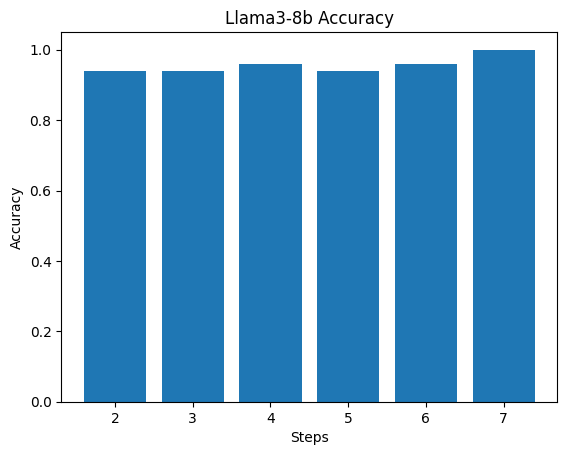

In [84]:
step_accs = [[0, 0] for _ in range(10)]
for q, a in zip(x, y):
    for k, v in a.items():
        question = q[k]
        step_accs[question['n_steps']][0] += int(v[0])
        step_accs[question['n_steps']][1] += 1

print(step_accs)
step_accs = [i[0] / i[1] for i in step_accs[2:8]]

import matplotlib.pyplot as plt

plt.ylabel("Accuracy")
plt.xlabel("Steps")
plt.title("Llama3-8b Accuracy")
plt.bar(list(range(2, 2+len(step_accs))), step_accs)

In [80]:
step_accs

[0.94, 0.94, 0.96, 0.94, 0.96, 1.0]

In [ ]:
[[0, 0], [0, 0], [94, 100], [94, 100], [96, 100], [94, 100], [96, 100], [100, 100], [0, 0], [0, 0]]
